In [4]:
import numpy as np
from glob import glob
import os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from skopt.space import Real
from skopt import BayesSearchCV

train_test_seed = 42

source_path = '../../datasets/QM9/xyz_c5h4n2o2_sorted/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

509

In [5]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap
sys.path.append(os.path.join(".."))
from utils import  flatten_triang, unflatten_triang, plot_fock_comparison

In [6]:
focks = []
used_files = []
reference_densities = []
for file in all_file_paths:
    mol_name = os.path.basename(file).split(".")[0]
    # print(mol_name)
    ret = density_fock_overlap(filepath = file,
                         filename = mol_name,
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp_sorted")
    if any([r == None for r in ret]): 
        print(f"File {mol_name} bad - skipping")
        continue
    focks.append(ret[1].numpy)
    used_files.append(file)
    reference_densities.append(ret[0].numpy)
print(f"Using {len(focks)} files from {len(all_file_paths)} total files")

File dsgdb9nsd_057125 bad - skipping
Using 508 files from 509 total files


In [7]:
from scf_guess_tools import Backend, load
from pyscf.gto import Mole
import re, time
import matplotlib.pyplot as plt

overlaps = []
for file in used_files:
    lines = open(file).readlines()
    q = int(re.search(r"charge\s+(-?\d+)", lines[1]).group(1))
    m = int(re.search(r"multiplicity\s+(\d+)", lines[1]).group(1))
    start_ = time.time()
    mol = Mole(atom=file, charge=q, spin=m - 1, symmetry=True)
    mol.basis = 'sto-3g'
    mol.build()
    S = mol.intor('int1e_ovlp')
    overlaps.append(np.asarray(S))
mat_size = overlaps[0].shape[0]

## Dataset split & scaling

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
import pickle

In [9]:
import pickle

overlaps_scaled_flat = np.array([flatten_triang(overlap) for overlap in overlaps]) # scaling only after train/test split
train, test = train_test_split(
    list(zip(focks, overlaps_scaled_flat, overlaps, used_files, reference_densities)), 
    test_size=0.2, 
    random_state=train_test_seed
)
# Scaling shouldn't influence test data! 
scaler_overlap = StandardScaler()


overlaps_train = [overlap_flat for _, overlap_flat, _, _, _ in train]
overlaps_test = [overlap_flat for _, overlap_flat, _, _, _ in test]

scaler_overlap.fit(overlaps_train)
overlaps_train = scaler_overlap.transform(overlaps_train)
overlaps_test = scaler_overlap.transform(overlaps_test)

# save back to train/test
train = [(fock, overlap_flat, overlap, file, ref_density) for (fock, _, overlap, file, ref_density), overlap_flat in zip(train, overlaps_train)]
test = [(fock, overlap_flat, overlap, file, ref_density) for (fock, _, overlap, file, ref_density), overlap_flat in zip(test, overlaps_test)]


with open("models/test_data.pkl", "wb") as f:
    pickle.dump(test, f)
with open("models/train_data.pkl", "wb") as f:
    pickle.dump(train, f)

y_train, X_train, _, _, _ = zip(*train)
y_test, X_test, _, _, _ = zip(*test)
# flatten y 
y_train = np.array([flatten_triang(y) for y in y_train])
y_test = np.array([flatten_triang(y) for y in y_test])

In [10]:
def summary(X, name):
    print(f"Summary {name}:")
    # print(f"Shape: {X.shape}")
    print(f"Mean: {np.mean(X)}")
    print(f"Std Dev: {np.std(X)}")
    print(f"Min: {np.min(X)}")
    print(f"Max: {np.max(X)}")

summary(X_train, "X_train")
summary(X_test, "X_test")

Summary X_train:
Mean: 4.314545213623208e-18
Std Dev: 0.9415575459019475
Min: -18.193841586980216
Max: 19.821583575277906
Summary X_test:
Mean: 0.007663873967544031
Std Dev: 1.087955930725705
Min: -21.109122135385064
Max: 155.15286323050452


In [11]:
# simple RR as proof of concept
model_path = "models/clean_ridge_model_standard_scalar.mpkl"
RETRAIN = False
Kernel_Ridge = False
if os.path.exists(model_path) and not RETRAIN:
    print("Loading model from disk...")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
else:
    base_model = RidgeCV(alphas=np.logspace(-2, 3, 10, base=10), cv=5)
    model = MultiOutputRegressor(base_model)
    start_ = time.time()
    model.fit(X_train, y=y_train)
    print(f"CV Training time: {time.time() - start_:.2f} seconds")
    best_alphas = np.array([estimator.alpha_ for estimator in model.estimators_])
    print(f"Best alphas: \nmean: {best_alphas.mean()}\nstd: {best_alphas.std()}\nmin: {best_alphas.min()}\nmax: {best_alphas.max()}")
    base_model = Ridge(alpha=best_alphas.mean())

    model = MultiOutputRegressor(base_model)

    start_ = time.time()
    model.fit(X_train, y=y_train)
    print(f"Refit-Training time: {time.time() - start_:.2f} seconds")

    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

#### Stats
# train err
y_train_pred = model.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
print(f"Train RMSE: {train_rmse}")

# test err
y_test_pred = model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Test RMSE: {test_rmse}")

sum_of_squares = np.mean(np.sum((np.zeros_like(y_test) - y_test)**2, axis=1))
print(f"Average sum of squares of y_test: {sum_of_squares:.4f}")

Loading model from disk...
Train RMSE: 0.0057317107547828735
Test RMSE: 0.03227952100122504
Average sum of squares of y_test: 1801.2192


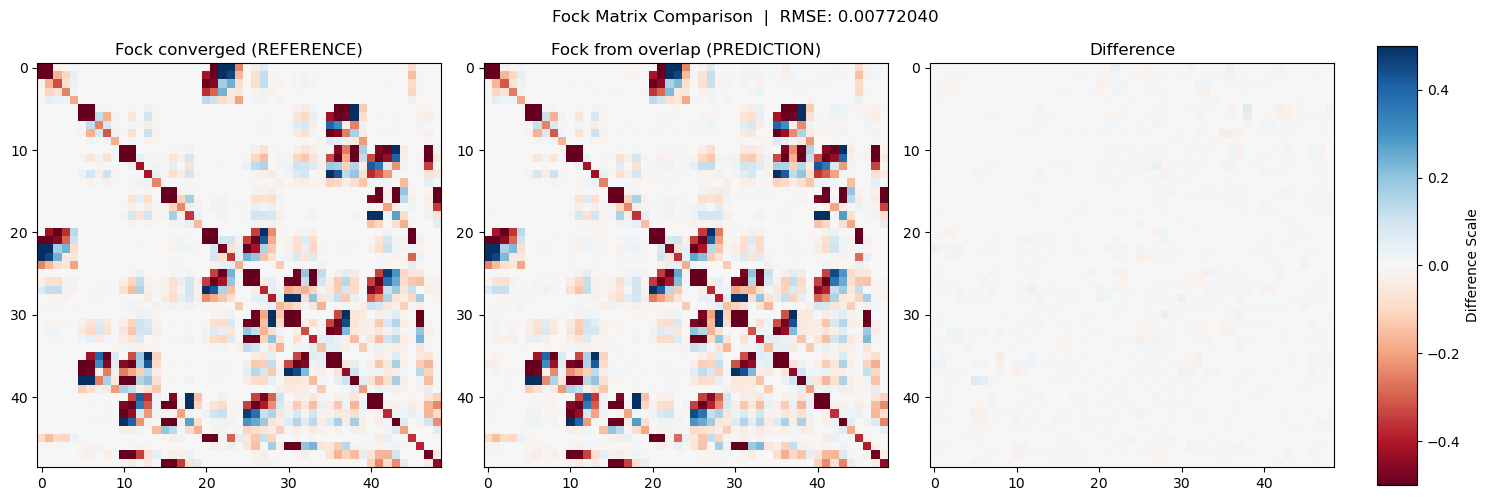

Model inference time: 0.06533573655521169 seconds


In [ ]:
plot_fock_comparison(y_train[0], y_train_pred[0], mat_size, vmax=0.5)

In [17]:
from scipy.linalg import eigh
def check_positive_definite(S, tol=1e-10):
    # Eigenwerte prüfen
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_pred(model, overlap, nocc, overlap_scaler, mat_dim=None): 
    """Overlap should be ORIGINAL, not transformed version!"""
    if overlap.ndim == 1: 
        assert mat_dim is not None
        overlap = unflatten_triang(overlap, mat_dim)
    transformed_overlap = overlap_scaler.transform(flatten_triang(overlap).reshape(1, -1))
    assert check_positive_definite(overlap)
    fock = model.predict(transformed_overlap)
    fock = unflatten_triang(fock, overlap.shape[0])
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = 2 * C_occ @ C_occ.T # *2 because of spin degeneracy
    return density

def comp_trace(overlap, *args): 
    for arg in args: 
        trace_ = np.trace(arg @ overlap)
        print(f"Trace: {trace_}")
    

In [228]:
# comparison density reconstruction
ref_densities = [ref_density for _, _, _, _, ref_density in test]
test_overlaps_orig = [overlap for _, _, overlap, _, _ in test]
density_preds = [density_pred(model, overlap, 32, scaler_overlap, mat_dim=mat_size) for overlap in test_overlaps_orig] # 15s

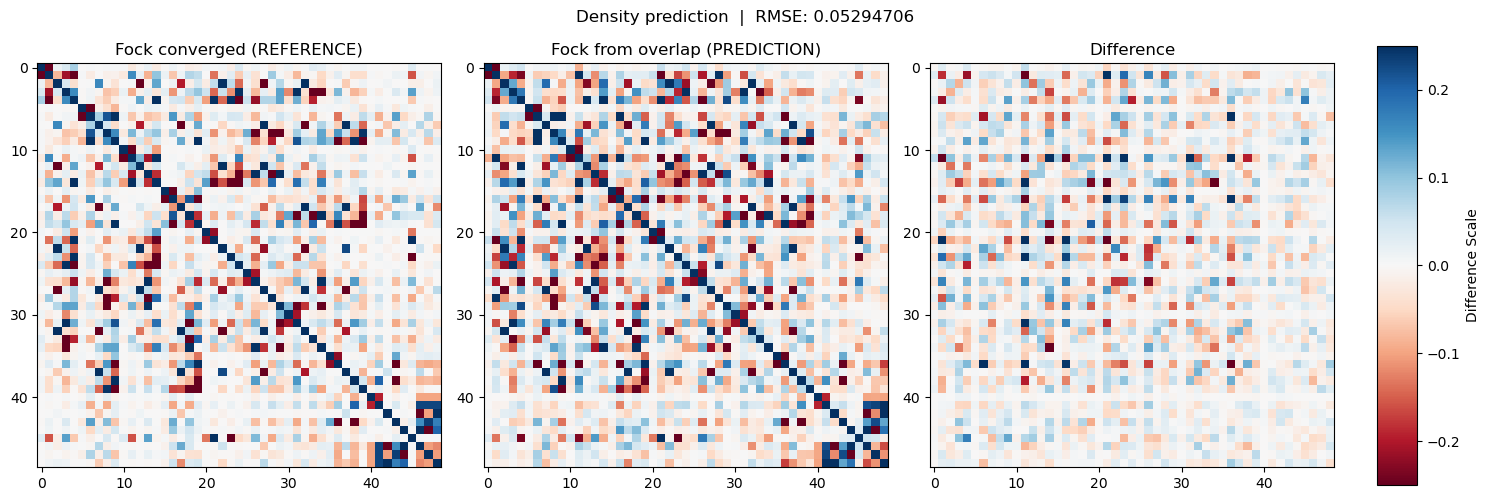

In [229]:
plot_fock_comparison(2*ref_densities[0], density_preds[0], mat_size, vmax=0.25, title="Density prediction")

In [230]:
from scf_guess_tools import build, f_score, Backend, calculate, guess
backend = Backend.PY
def get_mean_fscore(data_set):
    f_scores = []
    for fock, _, overlap, used_file, ref_density in data_set: 
        
        pred_density = density_pred(model, overlap, 32, scaler_overlap, mat_dim=mat_size)
        pred_density = build(pred_density, backend)
        ref_density = build(ref_density, backend)
        overlap = build(overlap, backend)
        
        fs = f_score(overlap, ref_density, pred_density) 
        f_scores.append(fs)

    mean_fs = np.mean(f_scores)
    std_fs = np.std(f_scores)
    print(f"Mean F-score: {mean_fs:.4f} +- {std_fs:.4f}")


get_mean_fscore(train)
get_mean_fscore(test)

Mean F-score: 0.9987 +- 0.0005
Mean F-score: 0.9320 +- 0.0424


Ok F-scores seem really good for a first try! -> Let's benchmark the first RR model! 

# Convergence Test

In [19]:
from scf_guess_tools import Backend, guess, calculate, load
from pyscf import scf

In [ ]:


def sim(file, overlap, model=model, scheme="1e", use_pred=False): 
    backend = Backend.PY
    mol = load(file, backend)
    mol_native = mol.native
    mol_native.basis = "sto-3g"
    mol_native.build()

    if use_pred: 
        start_ = time.time()
        D_ = density_pred(model, overlap, mol_native.nelec[0], scaler_overlap, mat_dim=mat_size) # nocc per shell
        mf = scf.RKS(mol_native)
        mf.xc = "b3lypg"
        print(f"Pred time, {time.time() - start_}")
        mf.kernel(dm0=D_) 
        wf = mf
        
    else: 
        wf = calculate(mol, basis="sto-3g", method="dft", functional="b3lypg", guess=scheme, cache=False)
        wf = wf.native
    print(f"SCF cycles: {wf.cycles}")
    return {"cycles": wf.cycles, "conv": wf.converged, "summary": wf.scf_summary}

def benchmark_model(model, dataset=test, scheme="1e", early_stop=50, only_ref=False, only_model=False):
    reference_time, model_time = [], []
    iterations = []
    for fock, overlap_scaled_flat, overlap, file, _ in dataset: # benchmark on test data! 
        print(f"File: {file}")
        res, res_ref = None, None
        if not only_model:
            start_ = time.time()
            res_ref = sim(file, overlap, model=model, scheme=scheme, use_pred=False)
            # print(res_ref)
            end_ = time.time()
            # print(f"Reference time: {end_ - start_:.2f} seconds")
            reference_time.append(end_ - start_)

        if not only_ref:
            start_ = time.time()
            res = sim(file, overlap, model=model, use_pred=True)
            # print(res)
            end_ = time.time()
            # print(f"Guess time: {end_ - start_:.2f} seconds")
            model_time.append(end_ - start_)
        res_it = res["cycles"] if res else None
        res_ref_it = res_ref["cycles"] if res_ref else None
        iterations.append((res_it, res_ref_it))    
        if early_stop < 0: 
            break
        early_stop -= 1
    return reference_time, model_time, iterations

In [233]:
_, model_time_model, iterations_model = benchmark_model(model, test, only_model=True)

File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_028121.xyz
Pred time, 0.1682887077331543
converged SCF energy = -446.946703900822
SCF cycles: 10
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_131581.xyz
Pred time, 0.21885013580322266
converged SCF energy = -446.816879401027
SCF cycles: 14
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_131100.xyz
Pred time, 0.20571470260620117
converged SCF energy = -446.808814673844
SCF cycles: 15
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_131749.xyz
Pred time, 0.21609711647033691
converged SCF energy = -446.832615178592
SCF cycles: 14
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_025279.xyz
Pred time, 0.19542789459228516
converged SCF energy = -446.954407732545
SCF cycles: 10
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_024377.xyz
Pred time, 0.22176909446716309
converged SCF energy = -446.937717046207
SCF cycles: 10
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_025119.xyz
Pred time, 0.1909

In [234]:
results = {"minao": None, "1e": None, "atom": None, "huckel": None, "vsap": None}
for key in results.keys():
    print(f"Starting with: {key}")
    reference_time, model_time, iterations = benchmark_model(model, test, scheme=key, only_ref=True, early_stop= 50)
    results[key] = {"reference_time": reference_time, "model_time": model_time, "iterations": iterations}
    

Starting with: minao
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900964
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_131581.xyz
converged SCF energy = -446.816879401012
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_131100.xyz
converged SCF energy = -446.808814674098
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_131749.xyz
converged SCF energy = -446.832615178595
SCF cycles: 12
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_025279.xyz
converged SCF energy = -446.954407732615
SCF cycles: 12
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_024377.xyz
converged SCF energy = -446.937717046223
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_025119.xyz
converged SCF energy = -446.882950708077
SCF cycles: 13
File: ../../datasets/QM9/xyz_c5h4n2o2_sorted/dsgdb9nsd_125474.xyz
converged SCF energy = -446.932670871209
SCF cycles: 11
Fil

In [2]:
import uncertainties as unc
from uncertainties import unumpy
import pandas as pd

In [216]:
# results for model
model_not_conv_perc = np.sum(np.array([it[0] for it in iterations_model]) >= 50) / len(iterations_model) 
model_time_conv = np.array([time for it, time in zip(iterations_model, model_time_model) if it[0] < 50])
model_it_conv = np.array([it[0] for it in iterations_model if it[0] < 50])

print(f"Model not converged percentage: {model_not_conv_perc:.3f}")
time_ = unc.ufloat(model_time_conv.mean(), model_time_conv.std())
it_ = unc.ufloat(model_it_conv.mean(), model_it_conv.std())
print(f"Model: {time_:.2f} seconds, {it_:.2f} iterations")
len(test)

Model not converged percentage: 0.038
Model: 4.99+/-0.87 seconds, 13.96+/-2.73 iterations


102

In [ ]:
results_df = pd.DataFrame({
    "Method": ["minao"] * len(results["minao"]["iterations"]) + ["1e"] * len(results["1e"]["iterations"]) + 
              ["atom"] * len(results["atom"]["iterations"]) + ["huckel"] * len(results["huckel"]["iterations"]) + 
              ["vsap"] * len(results["vsap"]["iterations"]),
    "Iterations": [it[0] for method in results.keys() for it in results[method]["iterations"]],
    "Times": [time for method in results.keys() for time in results[method]["reference_time"]]
})
results_df_conv = results_df[results_df["Iterations"] < 50]
results_df_not_conv = results_df[results_df["Iterations"] >= 50]
not_conv_perc = results_df_not_conv["Method"].value_counts() / len(results["vsap"]["iterations"])
print(f"Not converged percentage: {not_conv_perc}")

methods = results.keys()
mean_time = unumpy.uarray([results_df_conv[results_df_conv["Method"] == method]["Times"].mean() for method in methods], [results_df_conv[results_df_conv["Method"] == method]["Times"].std() for method in methods])
mean_it = unumpy.uarray([results_df_conv[results_df_conv["Method"] == method]["Iterations"].mean() for method in methods], [results_df_conv[results_df_conv["Method"] == method]["Iterations"].std() for method in methods])
for c, method in enumerate(methods):
    print(f"{method}: {mean_time[c]:.2f} seconds, {mean_it[c]:.2f} iterations")

NameError: name 'results' is not defined

## Inference Time Benchmark

In [21]:
import uncertainties as unc
# inference of model 
test_files = [file for _, _, _, file, _ in test]
mols = [load(file, Backend.PY) for file in test_files]
time_ = []
# Ridge is Benchmark
for mol, overlap in zip(mols, overlaps):
    start_ = time.time()
    density_pred(model, overlap, mol.native.nelec[0], scaler_overlap, mat_dim=mat_size)
    time_.append(time.time() - start_)
ref_time = unc.ufloat(np.mean(time_), np.std(time_))
print(f"Ridge time: {ref_time:.2f} seconds")
ridge_time = ref_time

scheme_times = []
# Comparison
for guessing_scheme in ["minao", "1e", "atom", "huckel", "vsap"]:
    print(f"Guessing scheme: {guessing_scheme}")
    time_ = []
    for mol in mols: 
        start_ = time.time()
        guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme=guessing_scheme, cache=False)
        time_.append(time.time() - start_)
    time_ = unc.ufloat(np.mean(time_), np.std(time_))
    scheme_times.append(time_)
    print(f"Time: {time_:.2f} seconds - {time_ / ref_time:.2f}x speedup")

Ridge time: 0.07+/-0.00 seconds
Guessing scheme: minao
Time: 0.10+/-0.04 seconds - 1.53+/-0.60x speedup
Guessing scheme: 1e
Time: 0.00+/-0.00 seconds - 0.07+/-0.02x speedup
Guessing scheme: atom
Time: 0.05+/-0.03 seconds - 0.75+/-0.49x speedup
Guessing scheme: huckel
Time: 0.05+/-0.03 seconds - 0.77+/-0.40x speedup
Guessing scheme: vsap
Time: 0.32+/-0.03 seconds - 4.89+/-0.50x speedup


In [22]:
minao_time = scheme_times[0]
for name, scheme in zip(["ridge", "1e", "atom", "huckel", "vsap"], [ridge_time, *scheme_times[1:]]): 
    print(f"Factor: {name}: {scheme / minao_time:.2f}x")


Factor: ridge: 0.65+/-0.26x
Factor: 1e: 0.05+/-0.02x
Factor: atom: 0.49+/-0.37x
Factor: huckel: 0.51+/-0.33x
Factor: vsap: 3.20+/-1.29x


## Mean Error Comp

In [38]:
test_files = [x[3] for x in test]
overlaps = [x[2] for x in test]
ref_densities = [x[4] for x in test]
from scf_guess_tools import guess, Backend
mols = [load(file, Backend.PY) for file in test_files]

In [39]:

minao_guesses = [guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme="minao", cache=False) for mol in mols]
vsap_guesses = [guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme="vsap", cache=False) for mol in mols]
minao_densities = [x.density().numpy for x in minao_guesses]
vsap_densities = [x.density().numpy for x in vsap_guesses]

In [40]:
minao_fock = [x.fock().numpy for x in minao_guesses]
vsap_fock = [x.fock().numpy for x in vsap_guesses]

In [41]:
minao_densities[0].shape

(49, 49)

In [49]:
ridge_densities = [1/2 * density_pred(model, overlap, mol.native.nelec[0], scaler_overlap, mat_dim=mat_size) for mol, overlap in zip(mols, overlaps)] # only one channel! 

In [50]:
reference_densities = [x[4] for x in test]
reference_focks = [x[0] for x in test]
reference_densities[0].shape

(49, 49)

Only alpha-electrons
MinAO mean trace: 31.7660
VSAP mean trace: 32.0000
Ridge mean trace: 32.0000
Reference mean trace: 32.0000


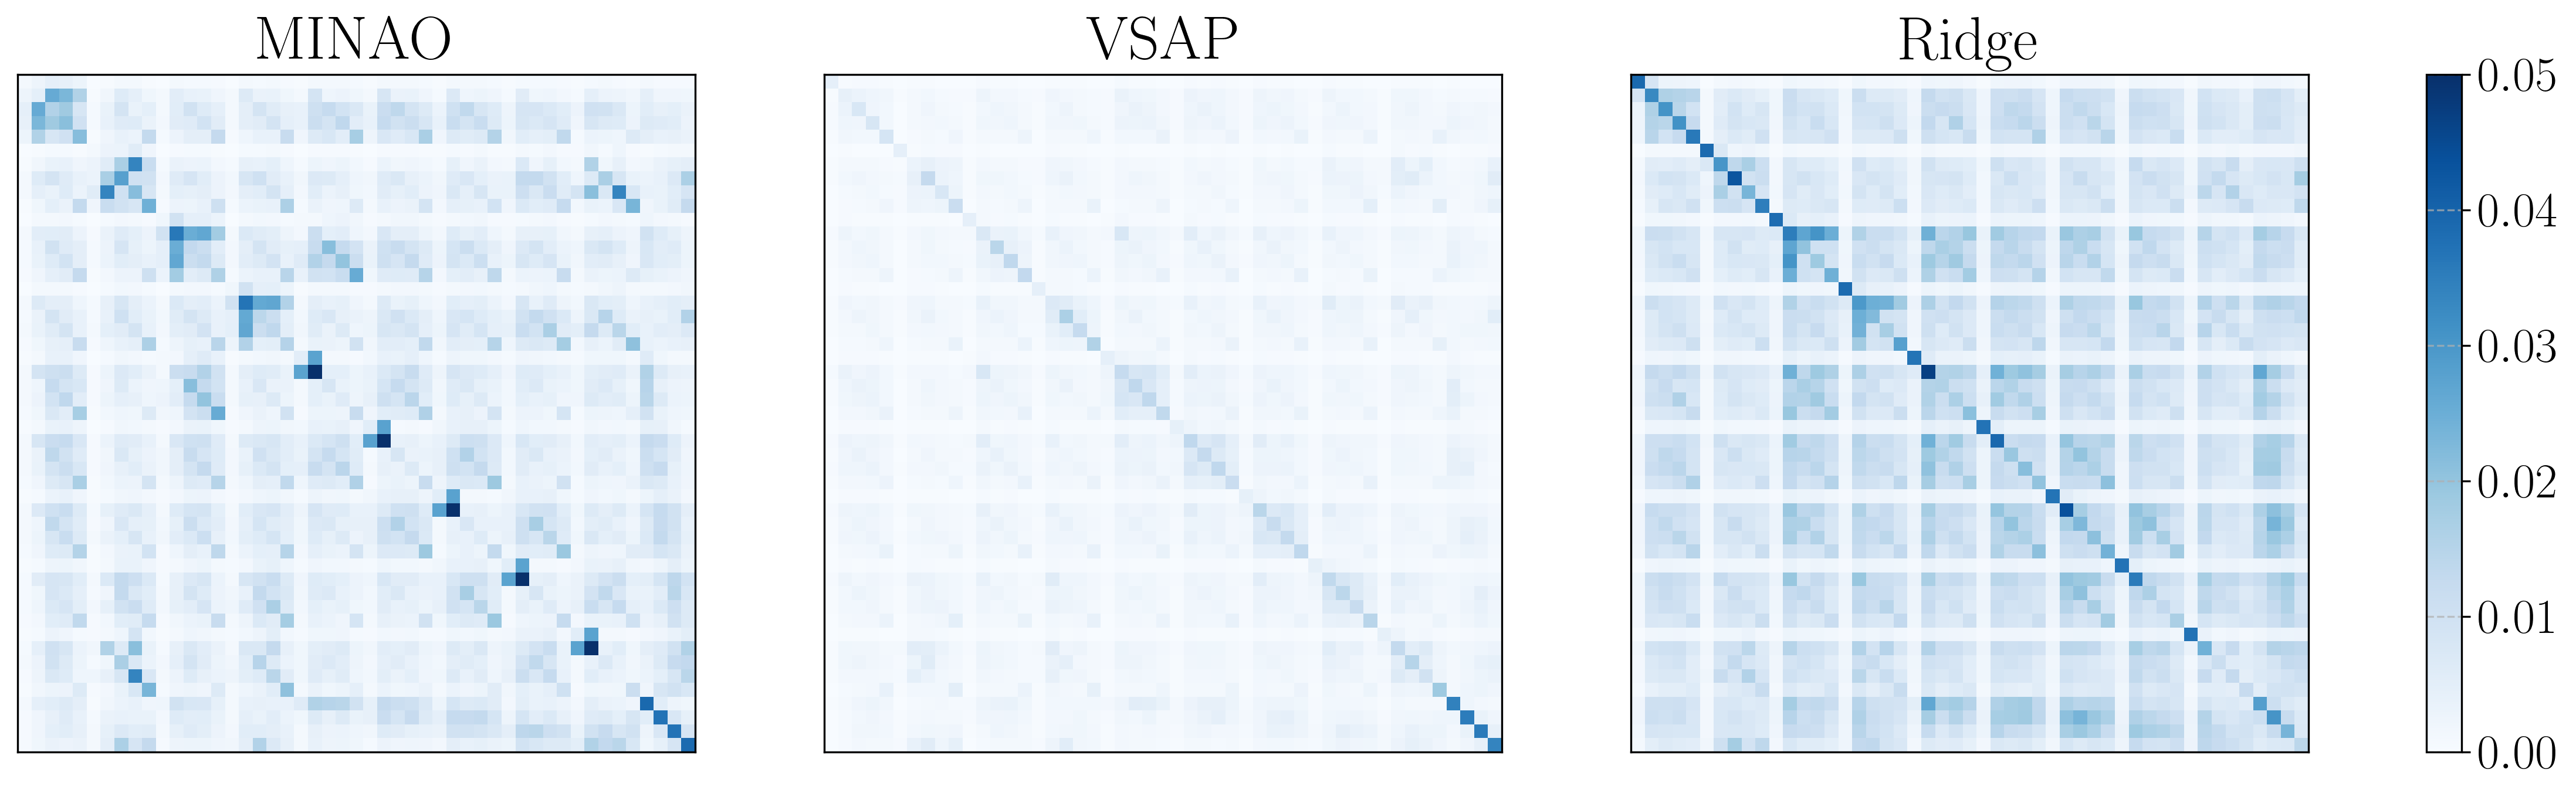

In [64]:
def normalize_data(minao_data, ridge_data, vsap_data, ref_data, overlaps):
    #! makes only sense if we project to orthonormal basis - Mulliken Population
    minao_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, minao_data)])
    vsap_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, vsap_data)])
    ridge_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, ridge_data)])
    ref_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, ref_data)])
    print("Only alpha-electrons")
    print(f"MinAO mean trace: {minao_mean_trace:.4f}")
    print(f"VSAP mean trace: {vsap_mean_trace:.4f}")
    print(f"Ridge mean trace: {ridge_mean_trace:.4f}")
    print(f"Reference mean trace: {ref_mean_trace:.4f}")
    
    minao_data = [density / np.linalg.norm(density) for density in minao_data]
    ridge_data = [density / np.linalg.norm(density) for density in ridge_data]
    vsap_data = [density / np.linalg.norm(density) for density in vsap_data]
    ref_data = [density / np.linalg.norm(density) for density in ref_data]


    # build difference! 
    delta_minao = [
        abs(density - ref_density) for density, ref_density in zip(minao_data, ref_data)
    ]
    delta_ridge = [
        abs(density - ref_density) for density, ref_density in zip(ridge_data, ref_data)
    ]
    delta_vsap = [
        abs(density - ref_density) for density, ref_density in zip(vsap_data, ref_data)
    ]


    delta_minao = np.mean(delta_minao, axis=0)
    delta_ridge = np.mean(delta_ridge, axis=0)
    delta_vsap = np.mean(delta_vsap, axis=0)

    # # renormalize to 1
    # delta_minao /= np.linalg.norm(delta_minao)
    # delta_ridge /= np.linalg.norm(delta_ridge)
    # delta_vsap /= np.linalg.norm(delta_vsap)
    return delta_minao, delta_ridge, delta_vsap

def plot_3_schemes(delta_minao_mean, delta_ridge_mean, delta_vsap_mean, filename="density_error_comparison", clipval=0.1):
    from matplotlib.colors import SymLogNorm
    plotting_script_base = "../../latex/scripts"
    sys.path.append(plotting_script_base)
    from plt_config import use_latex, TU_GREY, TU_RED
    use_latex()

    norm = SymLogNorm(linthresh=1e-2, linscale=0.7, vmin=0, vmax=clipval, base=10)
    # norm=None
    fig, ax = plt.subplots(1, 4, figsize=(18, 5), width_ratios=[1, 1, 1, 0.05])

    # Plot 1: MINAO
    im0 = ax[0].imshow(delta_minao_mean, cmap=plt.cm.Blues, vmin=0, vmax=clipval)
    ax[0].set_title("MINAO", fontsize=25)
    # fig.colorbar(im0, cax=ax[1])

    # Plot 2: VSAP
    im1 = ax[1].imshow(delta_vsap_mean, cmap=plt.cm.Blues, vmin=0, vmax=clipval)
    ax[1].set_title("VSAP", fontsize=25)
    # fig.colorbar(im1, cax=ax[3])

    # Plot 3: Ridge
    im2 = ax[2].imshow(delta_ridge_mean, cmap=plt.cm.Blues, vmin=0, vmax=clipval)
    ax[2].set_title("Ridge", fontsize=25)
    cbar = fig.colorbar(im2, cax=ax[3])
    cbar.ax.tick_params(labelsize=20)

    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])


    plt.savefig(f"../../latex/fig/c5h4n2o2/{filename}.pdf", bbox_inches='tight')
plot_3_schemes(*normalize_data(minao_densities, ridge_densities, vsap_densities, reference_densities, overlaps), filename="density_error_comparison", clipval=0.05)
# plot_3_schemes(*normalize_data(minao_fock, ridge_fock, vsap_fock, reference_focks, overlaps), filename="fock_error_comparison", clipval=0.001)